# Deep Learning

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os.path
import subprocess
import matplotlib.collections
import scipy.signal
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Use CPU rather than GPU for keras neural networks
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from tensorflow import keras
from tqdm.keras import TqdmCallback

2023-12-04 23:25:15.629321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <span style="color:Orange">Feedforward neural network</span>

A feedforward neural network is a function that was designed to mimic biological neural networks.
It can be written as simply
$$ \Large
y = f(W_lf(W_{l-1}(\cdot \cdot \cdot f(W_1\textbf{x} + \textbf{b}_1) \cdot \cdot \cdot) + \textbf{b}_{l-1}) + \textbf{b}_l).
$$
This may look confusing at first glance, but basically it is just a function that takes in a vector (or value) $\textbf{x}$ and outputs a value $y$.
This function is a nested function (in that it repeatedly applies the function $f$) and can be written more legibly as:
$$ \Large
y_1 = f(W_1\textbf{x} + \textbf{b}_1) \\
y_2 = f(W_2y_1 + \textbf{b}_2) \\
\vdots \\
y = f(W_ly_{l-1} + \textbf{b}_l)
$$
Note that at the $i^\text{th}$ level, $y_{i-1}$ is the input to the function.

### <span style="color:LightGreen">Structure</span>

You may be wondering how this is similar to biological neural networks. This is clearer if we write the above in a diagram form:

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/feedforward_nn1.drawio.svg)

For some terminology,
- $f$ is an "activation" function (something like $\tanh$)

- $W_i$ is called a "weight" matrix

- $b_i$ is called a "bias" vector

Because $W_i$ are matrices, they can change the dimension at each level.
For example, if our input $\textbf{x}$ was a vector of 3 items, and the matrix $W_1$ was a $5 \times 3$ matrix, then $W_1\textbf{x}$ would be a size 5 vector.
With this in mind, the above diagram is more commonly drawn as:

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/feedforward_nn2.drawio.svg)

This diagram shows how the function we wrote above is actually a network.
Each line on the diagram represents an operation like $W_{i,jk}y_{i,k} + b_j$ where $W_{i,jk}$ is the $j,k$ entry in the $W_i$ matrix.
Each circle is the application of the activation function $f$ (which could actually be different at each layer) and are usually called "nodes."
The network is called "feedforward" because data only flows from left to right (there are no loops).

Let's create a simple network with the following properties in the `keras` Python framework:
- $\textbf{x}$ is a vector of length 2

- $W_1,W_2$ are sizes $3\times 2$ and $1 \times 3$ respectively

- $b_1, b_2$ are vectors of size $3$ and $1$ respectively

- $f$ is a $\tanh$ function

In [3]:
# Set the random seed to make sure we get reproducible results (we get the same every time we run)
keras.utils.set_random_seed(0)

# Make input layer of appropriate size (1 sample of size 2)
x   = keras.layers.Input(shape=(2,),name="Input")

# Pass input x into first layer of size 3 x 2
y_1 = keras.layers.Dense(3,activation="tanh")(x)

# Pass middle or "hidden" layer into output
y   = keras.layers.Dense(1,activation="tanh")(y_1)

model = keras.Model(inputs=x,outputs=y)

Notice that the way to do this in `keras` is to make functions that you pass the other functions into.
So, `x` is a `keras` function and we want its output to be passed into the next function `y_1` and so on.
Each of these functions returns another Python function when called.
They are all ultimately combined into one big function in `model`.
More information on this method of creating a neural network with `keras` can be found [here](https://keras.io/guides/functional_api/).

We can now try putting a vector of size 2 into the network to see the output.

In [4]:
# 1 random sample of size 2
sample = np.random.random(size=(1,2))

print("Sample: {}".format(sample))
print("Result: {}".format(model(sample)))

Sample: [[0.5488135  0.71518937]]
Result: [[0.50497514]]


If we wanted to put in many samples of size 2 and see all of their outputs at the same time, we could write:

In [5]:
# 5 random samples of size 2
samples = np.random.random(size=(5,2))

print("Samples: \n{}".format(samples))
print("Results: \n{}".format(model(samples)))

Samples: 
[[0.60276338 0.54488318]
 [0.4236548  0.64589411]
 [0.43758721 0.891773  ]
 [0.96366276 0.38344152]
 [0.79172504 0.52889492]]
Results: 
[[0.38953546]
 [0.47595912]
 [0.60580003]
 [0.23124357]
 [0.3555    ]]


### <span style="color:LightGreen">Tuning the network</span>

To reiterate, the neural network is just a function.
You input $\textbf{x}$ and it outputs $y$.
For time series forecasting, we'd like to input a sequence of previous time series data $\textbf{x}$ and get out the next point in the series $y$.

In order to make our neural network model function accurate (to get the answer $y$ correct), we can adjust the weights $W_1,W_2,\ldots,W_l$ and biases $b_1,b_2,\ldots,b_l$.
We can do this by considering a "loss" function $\mathcal{L}(y,\hat{y})$ where $\hat{y}$ is the actual value and $y$ is the value predicted by the neural network.
A common loss is just the squared difference:
$$ \Large
\mathcal{L}(y,\hat{y}) = (y - \hat{y})^2
$$

Knowing that we want $y$ and $\hat{y}$ to be as close as possible to each other so that our network is accurate, we want to minimize $\mathcal{L}(y,\hat{y})$.
From calculus, we know we can take a derivative of $\mathcal{L}$ and set it to 0.
For a single parameter, this can be written as:
$$ \Large
\frac{d}{dW_i}\mathcal{L}(y,\hat{y}) = 0
$$

A significant amount of effort and programming has been put in to be able to automatically calculate these derivatives.
It is thus namely called "automatic differentiation."
Most neural network frameworks obscure these details and let you focus on just the network design (how many nodes, layers $l$, etc.).

Once we can calculate these derivatives, we can use a procedure called "gradient descent" to iteratively adjust the weights and biases to better match our data.
This process is usually called "training" the network.

The `keras` framework makes it easy to select a gradient descent type and loss function and fit to data.
Consider the following example where we have data samples of $x = [\sin(t),\cos(t)]$ for values of $t$ between $0$ and $10$ and we want to output the value $\sin(t)\cos(t)$.
We use the mean squared error loss and the gradient descenet algorithm `adam`.

0epoch [00:00, ?epoch/s]

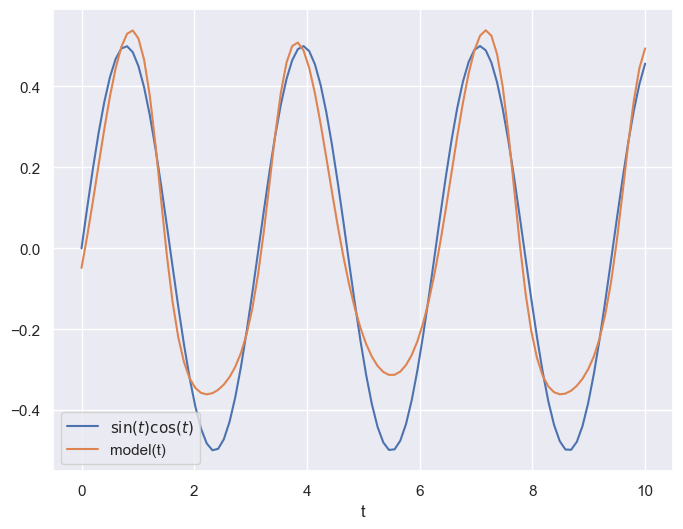

In [6]:
# Make our data samples
t_values = np.linspace(0,10,100)
samples = np.vstack([np.sin(t_values), np.cos(t_values)]).T
output_values = np.sin(t_values)*np.cos(t_values)

# Train model
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = model.fit(
    samples,
    output_values,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=500,            # The number of times to iterate through our dataset
    validation_split = 0.2,# Use 20% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

# Plot prediction and the true values
plt.close('all')
plt.figure(figsize=(8,6))
plt.plot(t_values, output_values, label="$\sin(t)\cos(t)$")
plt.plot(t_values, model(samples), label="model(t)")
plt.legend()
plt.xlabel("t")
plt.show()

Not bad!
Using automatic differentiation and gradient descent, the neural network weights and biases have been adjusted to make the neural network approximate the function $\sin(t)\cos(t)$.
It is not perfect, but it gets the general shape.
We could increase the number of `epochs` to train for longer and improve the accuracy.

## <span style="color:Orange">Recurrent Networks</span>

All the architectures we have seen so far are **feed-foward** networks, with input data always from left (input layer) to right (output layer). A <span style="color:Violet">recurrent neural network</span> (RNN) adds links that feed back into a previous layer. This simple modification adds significant complexity but also expressive power (comparable to the electronics revolution associated with the idea of transistor feedback).

Architectures with feedback are still maturing but some useful building blocks have emerged, such as the [long short-term memory unit](https://en.wikipedia.org/wiki/Long_short-term_memory), which allows a network to remember some internal state but also forget it based on new input.

Some practical considerations for RNN designs:
 - The order of training data is now significant and defines a "model time", but the network can be reset whenever needed.

 - Input data can be packaged into variable-length messages that generate variable (and different) length output messages. This is exactly what language translation needs.

 - Optimization of the weights using gradients is still possible but requires "unrolling" the network by cloning it enough times to process the longest allowed messages.

A feed-foward network implements a universal approximating function. Since the internal state of an RNN acts like local variables, you can think of an RNN as a universal approximating program.

See this [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) for an example based on natural language synthesis.

A "recurrent" neural network is not exactly feedforward.
There are a variety of forms for a recurrent network, but using the previous diagramming method, we can write the most common form as:

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn_loop.drawio.svg)

As you can see, there is a loop (the recurrent part) which passes information from one evaluation of the function to the next time the function is evaluated.
This might seem strange at first glance but makes more sense when you consider a sequence of events.
For example, words.
If we have three words of a sentence, predicting the next word likely depends on all three words rather than only the previous.

### <span style="color:LightGreen">Stucture</span>

The "looped" diagram shown above can also be written in an "unrolled" form as follows:

___<span style="color:Tan">Many-to-many</span>___

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn1.drawio.svg)

Note that this form of recurrent neural network requires inputs at each step and gives outputs at each step.
This is is not strictly necessary and you could instead have only the end output or only one input and one output as show below:

___<span style="color:Tan">Many-to-one</span>___
![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn2.drawio.svg)

___<span style="color:Tan">One-to-one</span>___
![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn3.drawio.svg)


Each of the demonstrated diagrams features a very simple version of the neural network, but it could have many layers at each step such as the following:

![](https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/diagrams/recurrent_nn_loop2.drawio.svg)


Fortunately, these can all be easily implemented using the `keras` framework.
Let's return to our example of input data of the form $[\sin(t),\cos(t)]$ and outputs of the form $\sin(t)\cos(t)$ but lets try to use 2 values of $t$ to get the next value.
So, we will pass in something like
$$
\begin{bmatrix}
\sin(t_1) & \cos(t_1) \\
\sin(t_2) & \cos(t_2)
\end{bmatrix}
$$
to get the output $\sin(t_3)\cos(t_3)$.
We'll use two layers.
See below for examples of these recurrent neural network forms:

In [7]:
keras.utils.set_random_seed(0)

# Make input layer of appropriate size (2 samples of size 2 or 1 sample of size 2)
x_many   = keras.layers.Input(shape=(2,2))
x_one    = keras.layers.Input(shape=(1,2))

# Pass input x into first layer of size 3 x 2
# return_sequences=True means there is an output for each input
y_many = keras.layers.SimpleRNN(3,activation="tanh", return_sequences=True)(x_many)
y_one  = keras.layers.SimpleRNN(3,activation="tanh", return_sequences=True)(x_one)
y_many_to_many = keras.layers.SimpleRNN(1,activation="tanh", return_sequences=True)(y_many)
y_many_to_one  = keras.layers.SimpleRNN(1,activation="tanh", return_sequences=False)(y_many)
y_one_to_one   = keras.layers.SimpleRNN(1,activation="tanh", return_sequences=False)(y_one)

many_to_many = keras.Model(inputs=x_many,outputs=y_many_to_many)
many_to_one  = keras.Model(inputs=x_many,outputs=y_many_to_one)
one_to_one   = keras.Model(inputs=x_one ,outputs=y_one_to_one)

In [8]:
# 1 batch of 2 random samples of size 2
sample_many = np.random.random(size=(1,2,2))
sample_one  = np.random.random(size=(1,1,2))

print("Sample of 2: \n{}".format(sample_many))
print("Many to many output: \n{}".format(many_to_many(sample_many)))
print("Many to one output: \n{}".format(many_to_one(sample_many)))
print("Sample of 1: \n{}".format(sample_one))
print("One to one output: \n{}".format(one_to_one(sample_one)))

Sample of 2: 
[[[0.5488135  0.71518937]
  [0.60276338 0.54488318]]]
Many to many output: 
[[[0.2860116]
  [0.5201849]]]
Many to one output: 
[[-0.04503517]]
Sample of 1: 
[[[0.4236548  0.64589411]]]
One to one output: 
[[0.37018642]]


The number passed into the `SimpleRNN` is the number of loops performed.
In the case described above, we want to take samples at times $t_1$ and $t_2$ and output the value of the function at time $t_3$.
This is a "many-to-one" case.

In order to train the network to perform well in this case, we need to arrange our data in pairs of
$$
\begin{bmatrix}
\sin(t_i) & \cos(t_{i}) \\
\sin(t_{i+1}) & \cos(t_{i+1})
\end{bmatrix}
$$ aligned with outputs $\sin(t_{i+2})\cos(t_{i+2})$:

In [10]:
# Arrange our data samples
input_samples = []
output_samples = []
for i in range(98):
  # Take two samples at time t_i and t_{i+1}
  input_samples.append(samples[i:i+2])
  # Get function output at time t_{i+2}
  output_samples.append(output_values[i+2])

input_samples = np.array(input_samples)
output_samples = np.array(output_samples)

We can now compile the many to one model and train it on this test data.

0epoch [00:00, ?epoch/s]

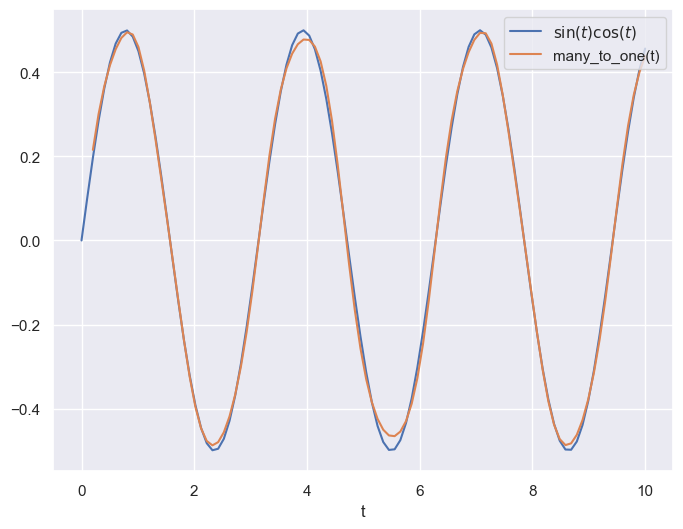

In [11]:
# Train model
many_to_one.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = many_to_one.fit(
    input_samples,
    output_samples,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=500,            # The number of times to iterate through our dataset
    validation_split = 0.2,# Use 20% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

# Plot prediction and the true values
plt.close('all')
plt.figure(figsize=(8,6))
plt.plot(t_values, output_values, label="$\sin(t)\cos(t)$")
plt.plot(t_values[2:], many_to_one(input_samples), label="many_to_one(t)")
plt.legend()
plt.xlabel("t")
plt.show()

## <span style="color:Orange">Convolutional Networks</span>

A _<span style="color:Violet">Convolutional Neural Network</span>_ (CNN) is a special architecture that:
 - Assumes that input features measure some property on a grid. The grid is usually spatial or temporal, but this is not required. For example, a 1D spectrum or time series, a 2D monochrome image, or a 3D stack of 2D images in different filters (RGB, etc).

 - Performs translation-invariant learning efficiently. For example, identifying a galaxy wherever it appears in an image, or a transient pulse wherever it appears in a time series. The main efficiency is a much reduced number of parameters compared to the number of input features, relative to the dense fully connected networks we have seen so far.

As we saw in the previous lecture, Neural Networks receive an input (a single vector), and transform it through a series of hidden layers. Each hidden layer is made up of a set of neurons, where each neuron is fully connected to all neurons in the previous layer, and where neurons in a single layer function completely independently and do not share any connections. The last fully-connected layer is called the “output layer” and in classification settings it represents the class scores.

The fully-connected, feed-forward neural networks we have studied thus far do not scale well to large image data. For example, a modest 200 $\times$ 200 $\times$ 3 (x-pixels, y-pixels, 3 colors) image would lead to neurons that have 200 $\times$ 200 $\times$ 3 = 120,000 weights. Moreover, we would almost certainly want to have several such neurons, so the parameters would add up quickly! Clearly, this full connectivity is wasteful and the huge number of parameters would quickly lead to overfitting.

Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way to reduce the number of parameters. In particular, unlike a regular Neural Network, the layers of a CNN have neurons arranged in 3 dimensions: width, height, depth. 

(Note that the word "depth" here refers to the third dimension of an activation volume, not to the depth of a full Neural Network, which can refer to the total number of layers in a network...) 

The neurons in a CNN layer will only be connected to a small region of the layer before it, instead of all of the neurons in a fully-connected manner.

A CNN is made up of layers of different types (convolutions, pooling, fully-connected), in general. Every layer has a simple API: It transforms an input 3D volume to an output 3D volume with some differentiable function that may or may not have parameters.

We will use the following problem to motivate and demonstration a CNN:

 - The input data consists of triplets of digitized waveforms.

 - Each waveform has a slowly varying level with some narrow pulses superimposed.

 - Each triplet has a single pulse that is synchronized (coincident) in all three waveforms.

 - Waveforms also contain a random number of unsynchronized "background" pulses.

 - Synchronized and unsynchronized pulses can overlap in time and between traces.

The goal is to identify the location of the synchronized pulses in each triplet. This is a simplified version of a common task in data acquisition trigger systems and transient analysis pipelines.

In [12]:
def generate(N=10000, ntrace=3, nt=100, nbg=1., A=5., nsmooth=3, T=1., seed=123):
    gen = np.random.RandomState(seed=seed)
    t_grid = np.linspace(0., T, nt)
    # Generate the smooth background shapes as superpositions of random cosines.
    wlen = 2 * T * gen.lognormal(mean=0., sigma=0.2, size=(nsmooth, N, ntrace, 1))
    phase = gen.uniform(size=wlen.shape)
    X = np.cos(2 * np.pi * (t_grid + phase * wlen) / wlen).sum(axis=0)
    # Superimpose short pulses.
    sigma = 0.02 * T
    tsig = T * gen.uniform(0.05, 0.95, size=N)
    y = np.empty(N, dtype=int)
    nbg = gen.poisson(lam=nbg, size=(N, ntrace))
    for i in range(N):
        # Add a coincident pulse to all traces.
        xsig = A * np.exp(-0.5 * (t_grid - tsig[i]) ** 2 / sigma ** 2)
        y[i] = np.argmax(xsig)
        X[i] += xsig
        # Add non-coincident background pulses to each trace.
        for j in range(ntrace):
            if nbg[i, j] > 0:
                t0 = T * gen.uniform(size=(nbg[i, j], 1))
                X[i, j] += (A * np.exp(-0.5 * (t_grid - t0) ** 2 / sigma ** 2)).sum(axis=0)
    return X.astype(np.float32), y

X, y = generate()

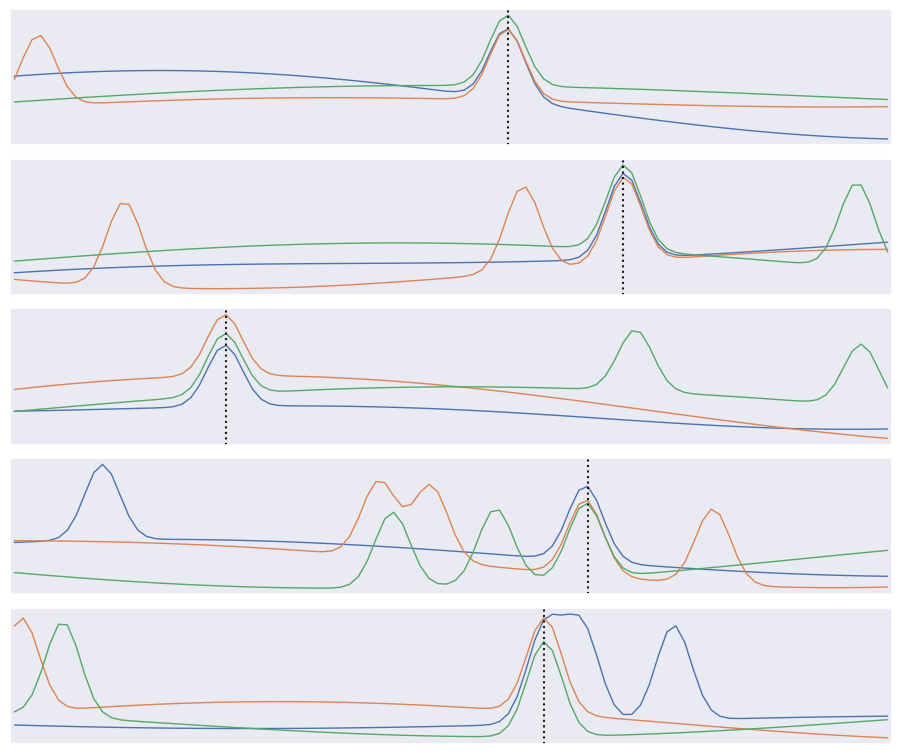

In [13]:
def plot_traces(X, y):
    Nsample, Ntrace, D = X.shape
    _, ax = plt.subplots(Nsample, 1, figsize=(9, 1.5 * Nsample))
    t = np.linspace(0., 1., 100)
    dt = t[1] - t[0]
    for i in range(Nsample):
        for j in range(Ntrace):
            ax[i].plot(t, X[i, j], lw=1)
        ax[i].axvline(t[y[i]], c='k', ls=':')
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_xlim(-0.5 * dt, 1 + 0.5 * dt)
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, hspace=0.1)

plot_traces(X[:5], y[:5])

The derivative of $f(x)$ can be approximated as

$$ \Large
f'(x) \simeq \frac{f(x + \delta) - f(x - \delta)}{2\delta}
$$

for small $\delta$. We can use this approximation to convert an array of $f(n \Delta x)$ values into an array of estimated $f'(n \Delta x)$ values using:
```
K = np.array([-1, 0, +1]) / ( 2 * dx)
fp[0] = K.dot(f[[0,1,2]])
fp[1] = K.dot(f[[1,2,3]])
...
fp[N-2] = K.dot(f[[N-3,N-2,N-1]]
```
The numpy [convolve function](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.convolve.html) automates this process of sliding an arbitrary <span style="color:Violet">kernel</span> $K$ along an input array like this. The result only estimates a first (or higher-order) derivative when the kernel contains [special values](https://en.wikipedia.org/wiki/Finite_difference_coefficient) (and you should normally use the numpy [gradient function](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.gradient.html) for this), but any convolution is a valid and potentially useful transformation.

A clarifying word about terminology: In the context of convolutional networks, <span style="color:Violet">kernel</span> is a simple group of weights shared all over the input space that is engineered to determine what specific features are to be detected. The kernel is also sometimes referred to as a "feature map" or "filter" in this context.

See for example the application of a kernel in convolution over a simple black-and-white image:
[here](https://i.stack.imgur.com/9Iu89.gif).


The kernel needs to completely overlap the input array it is being convolved with, which means that the output array is smaller and offset. Alternatively, you can pad the input array with zeros to extend the output array. There are three different conventions for handling these edge effects via the `mode` parameter to `np.convolve`:
 - **valid**: no zero padding, so output length is $N - K + 1$ and offset is $(K-1)/2$.

 - **same**: apply zero padding and trim so output length equals input length $N$, and offset is zero.

 - **full**: apply zero padding without trimming, so output length is $N + K - 1$ and offset is $-(K-1)/2$.

(Here $N$ and $K$ are the input and kernel lengths, respectively).

We can use a convolution to identify features in our input data:

In [14]:
def plot_convolved(x, kernel, smax=50):
    t = np.arange(len(x))
    plt.plot(t, x, lw=1, c='gray')
    z = np.convolve(x, kernel, mode='same')
    for sel, c in zip(((z > 0), (z < 0)), 'rb'):
        plt.scatter(t[sel], x[sel], c=c, s=smax * np.abs(z[sel]), lw=0)
    plt.gca()
    plt.grid(False)

First, let's pick out regions of large positive (red) or negative slope (notice how the edge padding causes some artifacts):

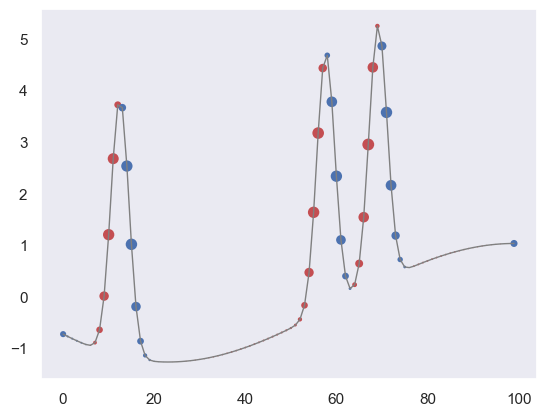

In [15]:
plot_convolved(X[1, 1], [0.5,0,-0.5])

We can also pick out regions of large curvature (using the finite-difference coefficients for a second derivative):

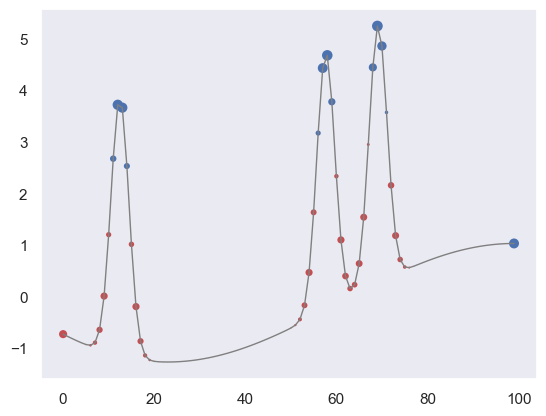

In [16]:
plot_convolved(X[1, 1], [1.,-2.,1.])

We can apply both of these convolutions to transform our input data to a new representation that highlights regions of large first or second derivative. Use a `tanh` activation to accentuate the effect:

In [17]:
def apply_convolutions(X, *kernels):
    N1, N2, D = X.shape
    out = []
    for i in range(N1):
        sample = []
        for j in range(N2):
            for K in kernels:
                sample.append(np.tanh(np.convolve(X[i, j], K, mode='valid')))
        out.append(sample)
    return np.asarray(out)

In [18]:
out = apply_convolutions(X, [0.5,0,-0.5], [1.,-2.,1.])

The resulting array can be viewed as a synthetic image and offers an easy way to visually identify individual narrow peaks and their correlations between traces:

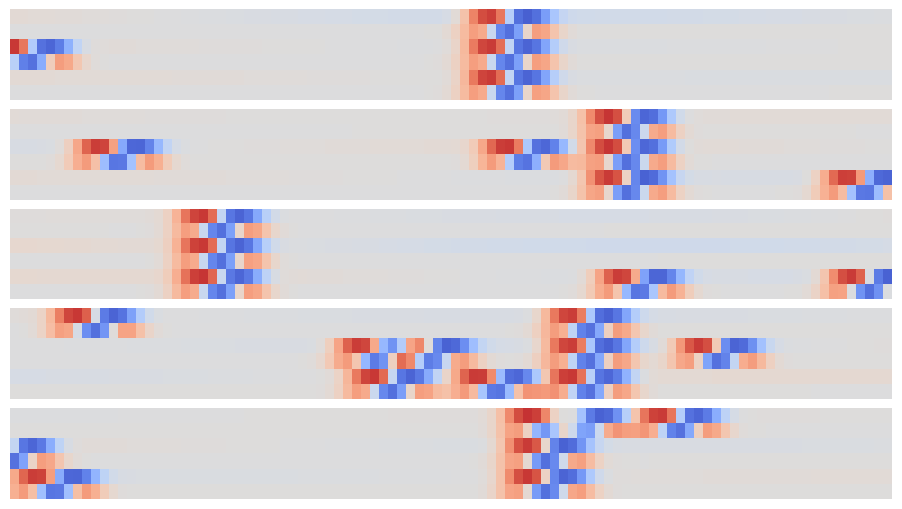

In [19]:
def plot_synthetic(Z):
    _, ax = plt.subplots(len(Z), 1, figsize=(9, len(Z)))
    for i, z in enumerate(Z):
        ax[i].imshow(z, aspect='auto', origin='upper', interpolation='none',
                   cmap='coolwarm', vmin=-1, vmax=+1);
        ax[i].grid(False)
        ax[i].axis('off')
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, hspace=0.1)

plot_synthetic(out[:5])

The patterns that identify individual and coincident peaks are all translation invariant so can be identified in this array using a new convolution, but now in the 2D space of these synthetic images.

Since matrix convolution is a linear operation, it is a special case of our general neural network unit,

$$ \Large
\mathbf{f}(\mathbf{x}) = W\mathbf{x} + \mathbf{b} \; ,
$$

but with the matrix $W$ now having many repeated elements so its effective number of dimensions is greatly reduced in typical applications.

A <span style="color:Violet">convolutional layer</span> takes an arbitrary input array and applies a number of filters with the same shape in parallel. By default, the filter kernels march with single-element steps through the input array, but you can also specify larger <span style="color:Violet">stride vector</span>.

In the general case, the input array, kernels and stride vector are all multidimensional, but with the same dimension. Tensorflow provides convenience functions for 1D, 2D and 3D convolutional layers, for example:
```
hidden = tf.layers.Conv2D(
    filters=3, kernel_size=[4, 5], strides=[2, 1],
    padding='same', activation=tf.nn.relu)
```
Note that `padding` specifies how edges effects are handled, but only `same` and `valid` are supported (and `valid` is the default). You can also implement higher-dimensional convolutional layers using the lower-level APIs.

A _<span style="color:Violet">convolutional neural network</span>_ (CNN) is a network containing convolutional layers. A typical architecture starts with convolutional layers, processing the input, then finishes with some fully connected dense layers to calculate the output. Since one of the goals of a CNN is reduce the number of parameters, a CNN often also incorporates [pooling layers](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer) to reduce the size of the array fed to to later layers by "downsampling" (typically using a maximum or mean value). See [these Stanford CS231n notes](http://cs231n.github.io/convolutional-networks/) for more details in the context of image classification.

In [20]:
def pulse_model(features, labels, mode, params):
    """Build a graph to TRAIN/TEST/PREDICT a pulse coincidence detection model.
    """
    D = params['time_steps']
    M = params['number_of_traces']
    n1 = params['conv1_width']
    n2 = params['conv2_width']
    eta = params['learning_rate']
    assert n1 % 2 == 1 and n2 % 2 == 1

    # Build the input layer.
    inputs = tf.reshape(features['X'], [-1, M, D, 1])
    # Add the first convolutional layer.
    conv1 = tf.layers.conv2d(
        inputs=inputs, filters=2, kernel_size=[1, n1],
        padding='same', activation=tf.tanh, name='conv1')
    # Add the second convolutional (and output) layer.
    logits = tf.layers.conv2d(
        inputs=conv1, filters=1, kernel_size=[M, n2],
        padding='valid', activation=None, name='conv2')
    # Flatten the outputs.
    logits = tf.reshape(logits, [-1, D - n2 + 1])

    # Calculate the offset between input labels and the output-layer node index
    # that is introduced by using padding='valid' for the output layer below.
    offset = (n2 - 1) // 2

    # Calculate the network's predicted best label.
    predicted_labels = tf.argmax(logits, axis=1) + offset

    # Calculate the network's predicted probability of each label.
    probs = tf.nn.softmax(logits)

    # Calculate the network's predicted mean label.
    bins = tf.range(0., D - n2 + 1., dtype=np.float32) + offset
    mean_labels = tf.reduce_sum(bins * probs, axis=-1)

    # Return predicted labels and probabilities in PREDICT mode.
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions={
            'label': predicted_labels,
            'probs': tf.nn.softmax(logits)
        })

    # Calculate the loss for TRAIN and EVAL modes. We need to offset the labels
    # used here so they correspond to output-layer node indices.
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels - offset, logits=logits)

    # Compute evaluation metrics.
    if mode == tf.estimator.ModeKeys.EVAL:
        accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_labels)
        rmse = tf.metrics.root_mean_squared_error(
            labels=tf.cast(labels, np.float32), predictions=mean_labels)
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops={'accuracy': accuracy, 'rmse': rmse})

    # Create optimizer.
    assert mode == tf.estimator.ModeKeys.TRAIN
    optimizer = tf.train.AdamOptimizer(learning_rate=eta)
    step = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=step)

In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

tf.logging.set_verbosity(tf.logging.WARN)

Instructions for updating:
non-resource variables are not supported in the long term
2.12.0


In [22]:
!rm -rf tfs/pulses

In [23]:
config = tf.estimator.RunConfig(
    model_dir='tfs/pulses',
    tf_random_seed=123
)

Instructions for updating:
Use tf.keras instead.


In [24]:
pulse = tf.estimator.Estimator(
    config=config,
    model_fn=pulse_model,
    params = dict(
        time_steps=100,
        number_of_traces=3,
        conv1_width=3,
        conv2_width=7,
        learning_rate=0.01))

Instructions for updating:
Use tf.keras instead.


In [25]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.4, random_state=123)

In [26]:
pulse.train(
    input_fn=tf.estimator.inputs.numpy_input_fn(
        x={'X': X_train}, y=y_train,
        batch_size=500, num_epochs=None, shuffle=True),
    steps=500);


Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


2023-12-04 23:25:42.310996: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: Enqueue operation was cancelled
	 [[{{node enqueue_input/random_shuffle_queue_EnqueueMany}}]]
2023-12-04 23:25:42.331987: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: Queue '_0_enqueue_input/random_shuffle_queue' is already closed.
	 [[{{node enqueue_input/random_shuffle_queue_Close}}]]


Evaluate how well the trained network performs on the test data:

In [27]:
results = pulse.evaluate(
    input_fn=tf.estimator.inputs.numpy_input_fn(
        x={'X': X_test}, y=y_test,
        num_epochs=1, shuffle=False))

Instructions for updating:
Use tf.keras instead.


We find that about 95% of test samples are classified "correctly", defined as the network predicting the bin containing the the coincidence maximum exactly.  However, The RMS error between the predicted and true bins is only 0.4 bins, indicating that the network usually predicts a neighboring bin in the 5% of "incorrect" test cases.

In [28]:
results

{'accuracy': 0.932, 'loss': 0.20110953, 'rmse': 0.36446783, 'global_step': 500}

Finally, compare the predicted (gray histogram) and true (dotted line) coincidence locations for a few test samples:

Instructions for updating:
Use tf.keras instead.


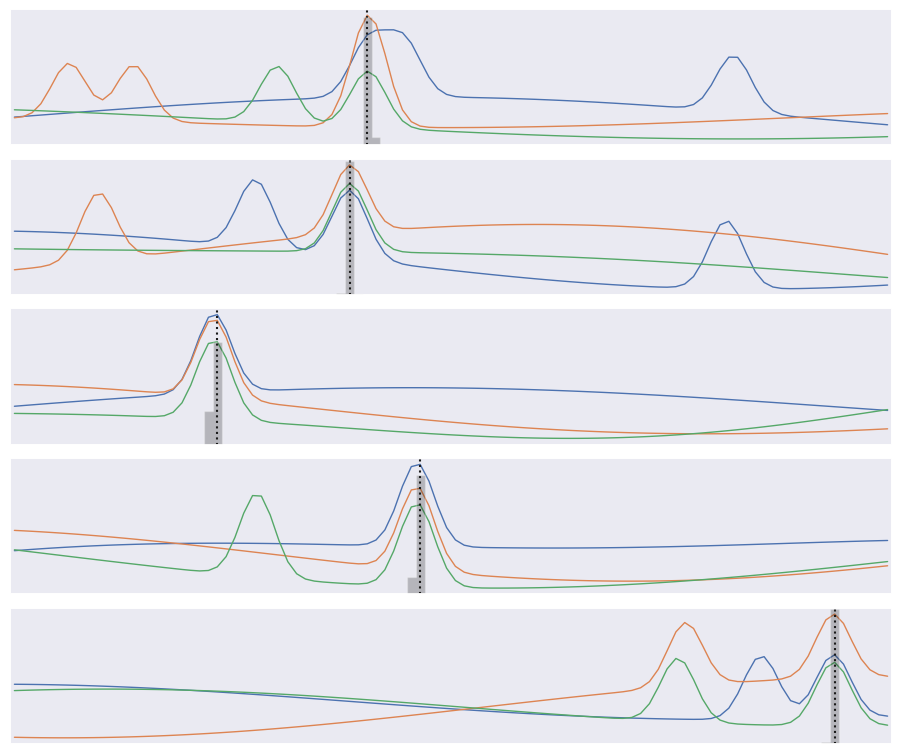

In [29]:
def plot_predictions(X, y):
    # Calculate predicted labels and PDFs over labels.
    predictions = pulse.predict(
        input_fn=tf.estimator.inputs.numpy_input_fn(
            x={'X': X}, y=None, num_epochs=1, shuffle=False))
    Nsample, Ntrace, D = X.shape
    t = np.linspace(0., 1., 100)
    dt = t[1] - t[0]
    bins = np.linspace(-0.5 * dt, 1 + 0.5 * dt, len(t) + 1)
    probs = np.zeros(D)
    # Plot input data, truth, and predictions.
    _, ax = plt.subplots(Nsample, 1, figsize=(9, 1.5 * Nsample))
    for i, pred in enumerate(predictions):
        label = pred['label']
        # Plot the input traces.
        for x in X[i]:
            ax[i].plot(t, x, lw=1)
        # Indicate the true coincidence position.
        ax[i].axvline(t[y[i]], c='k', ls=':')
        # Indicate the predicted probability distribution.
        n2 = D - len(pred['probs']) + 1
        offset = (n2 - 1) // 2
        probs[offset:-offset] = pred['probs']
        rhs = ax[i].twinx()
        rhs.hist(t, weights=probs, bins=bins, histtype='stepfilled', alpha=0.25, color='k')
        rhs.set_ylim(0., 1.)
        rhs.set_xlim(bins[0], bins[-1])
        rhs.set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].grid(False)
        ax[i].set_xlim(bins[0], bins[-1])
    plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, hspace=0.1)

plot_predictions(X_test[:5], y_test[:5])

Note that our loss function does not know that consecutive labels are close and being off by one is almost as good as getting the right label. We could change this by treating this as a regression problem, but a nice feature of our multi-category approach is that we can predict a a full probability density over labels (the gray histograms above) which is often useful.

## <span style="color:Orange">Reinforcement Learning</span>

The architectures we have seen so far all have target output values associated with each input sample, which are necessary to update the network parameters during the learning (loss optimization) phase:

<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/DeepLearning-SampleLearning.png" width=600 align=left></img><br>

However, we can relax this requirement of being able to calculate a loss after each new input as long as we eventually get some feedback on how well our input-to-output mapping is doing.  This is the key idea of <span style="color:Violet">reinforcement learning</span> (RL):

<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/DeepLearning-ReinforcementLearning.png" width=600 align=left></img><br>

A RL network watches some external "reality" (which is often simulated) and learns a policy for how to take actions.  A sequence of actions eventually leads to some feedback, which is then used to take a single step in optimizing the policy network's parameters:

See this [blog post](http://karpathy.github.io/2016/05/31/rl/) for an example based on image generation.

<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/DeepLearning-PolicyNetwork.png" width=600 align=left></img><br>

See this [blog post](http://karpathy.github.io/2016/05/31/rl/) for an example based on image generation.

## <span style="color:Orange">Deep Learning Outlook</span>

The depth of "deep learning" comes primarily from network architectures that stack many layers. In another sense, deep learning is very shallow since it often performs well using little to no specific knowledge about the problem it is solving, using generic building blocks.

The field of modern deep learning [started around 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) when the architectures described above were first used successfully, and the necessary large-scale computing and datasets were available. Massive neural networks are now the state of the art for many benchmark problems, including image classification, speech recognition and language translation.

However, less than a decade into the field, there are signs that deep learning is reaching its limits. Some of the pioneers and others are taking a [critical look](https://arxiv.org/abs/1801.00631) at the current state of the field:
 - Deep learning does not use data efficiently.

 - Deep learning does not integrate prior knowledge.

 - Deep learning often give correct answers but without associated uncertainties.

 - Deep learning applications are hard to interpret and transfer to related problems.

 - Deep learning is excellent at learning stable input-output mappings but does not cope well with varying conditions.

 - Deep learning cannot distinguish between correlation and causation.

These are mostly concerns for the future of neural networks as a <span style="color:Violet">general model for artificial intelligence</span>, but they also limit the potential of scientific applications.

However, there are many challenges in scientific data analysis and interpretation that could benefit from deep learning approaches, so I encourage you to follow the field and experiment. Through this course, you now have a pretty solid foundation in data science and machine learning to further your studies toward more advanced and current topics!